# Reinforcement Learning

# Recommender System

Imagine a streaming platform with a homepage of movies that are recommended to you. When you sign in for the first time, your preferences are unknown. This is known as the **cold-start** problem. 

The objective of this notebook is to exploit the interests of a user in a few movies to learn her / his 
 **preferences** over the whole catalogue.

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
from base64 import b64decode

You will need ``ipywidgets`` to simulate the interactions with the user.

In [2]:
!pip install ipywidgets

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
from IPython import display
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data

We work on a catalogue of 1037 movies available in 2015.

In [6]:
df = pd.read_pickle("movie_database.pickle")

In [7]:
len(df)

1037

### Movie features

In [8]:
df.head()

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster
0,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",Won 1 Oscar. Another 15 wins & 18 nominations.,[USA],[Irvin Kershner],"[Action, Adventure, Fantasy]",[English],[PG],1980-06-20,Star Wars: Episode V - The Empire Strikes Back,tt0080684,8.8,79.0,290158751.0,799579.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,"[Kareem Abdul-Jabbar, Lloyd Bridges, Peter Gra...",Nominated for 1 Golden Globe. Another 2 wins &...,[USA],"[Jim Abrahams, David Zucker, Jerry Zucker]",[Comedy],[English],[PG],1980-07-02,Airplane!,tt0080339,7.8,NaN,83400000.0,154994.0,88.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,"[John Belushi, Dan Aykroyd, James Brown, Cab C...",1 win.,[USA],[John Landis],"[Action, Comedy, Crime]",[English],[R],1980-06-20,The Blues Brothers,tt0080455,7.9,NaN,54200000.0,138196.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,"[Jack Nicholson, Shelley Duvall, Danny Lloyd, ...",3 wins & 5 nominations.,"[USA, UK]",[Stanley Kubrick],"[Drama, Horror]",[English],[R],1980-05-23,The Shining,tt0081505,8.4,61.0,NaN,584323.0,146.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


- `imdbID`: Unique IMDB id
- `Actors`: List of actors in the movie
- `Awards`: Description of awards received
- `Country`: Origin of the movie
- `Director`: List of directors
- `Genre`: List of genres
- `Language`: Language spoken
- `Rated`: Public rating classification (PG, R, etc.)
- `Released`: Date of release
- `Runtime`: Movie duration in minutes
- `Title`: Title of the movie
- `imdbRating`: Rating between 0 and 10
- `Metascore`: Metacritic score between 0 and 100
- `Box_office`: Total money generated
- `imdbVotes`: Number of votes
- `poster`: Image bytes of the poster

In [9]:
CAT_FEATURES = [
    "Actors",
    "Country",
    "Director",
    "Genre",
    "Rated"
]

NUM_FEATURES = [
    "imdbRating",
    "Metascore",
    "Box_office",
    "imdbVotes",  
]

### Movie poster

Here is an example of a movie poster.

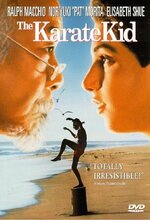

In [10]:
display.Image(df.loc[12].poster)

## Train / test

Like Netflix, we assume that the homepage consists of lists of movies grouped by category.
We will focus on the category **"Movies released in 2015"**.

Let's split the data into train and test.

In [11]:
train_movies = df[df.Released.dt.year < 2015]
test_movies = df[df.Released.dt.year == 2015]

In [12]:
test_movies

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster
963,"[Bradley Cooper, Kyle Gallner, Cole Konis, Ben...",Won 1 Oscar. Another 16 wins & 33 nominations.,[USA],[Clint Eastwood],"[Action, Biography, Drama]","[English, Arabic]",[R],2015-01-16,American Sniper,tt2179136,7.3,72.0,350123553.0,307331.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1006,"[Steve Carell, Channing Tatum, Mark Ruffalo, S...",Nominated for 5 Oscars. Another 11 wins & 71 n...,[USA],[Bennett Miller],"[Biography, Drama, Sport]","[English, French]",[R],2015-01-16,Foxcatcher,tt1100089,7.0,81.0,12096300.0,100844.0,134.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1009,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",3 wins & 48 nominations.,"[USA, Japan]",[Colin Trevorrow],"[Action, Adventure, Sci-Fi]",[English],[PG-13],2015-06-12,Jurassic World,tt0369610,7.1,59.0,652177271.0,380404.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1010,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",2 wins & 25 nominations.,[USA],[Joss Whedon],"[Action, Adventure, Sci-Fi]",[English],[PG-13],2015-05-01,Avengers: Age of Ultron,tt2395427,7.5,66.0,458991599.0,401155.0,141.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1011,"[Amy Poehler, Phyllis Smith, Richard Kind, Bil...",Won 1 Oscar. Another 73 wins & 86 nominations.,[USA],"[Pete Docter, Ronnie Del Carmen]","[Animation, Adventure, Comedy]",[English],[PG],2015-06-19,Inside Out,tt2096673,8.3,94.0,356454367.0,287471.0,95.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1012,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",Nominated for 1 Golden Globe. Another 15 wins ...,"[USA, Japan, China]",[James Wan],"[Action, Crime, Thriller]",[English],[PG-13],2015-04-03,Furious 7,tt2820852,7.3,67.0,350034110.0,260137.0,137.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1013,"[Sandra Bullock, Jon Hamm, Michael Keaton, All...",Nominated for 1 BAFTA Film Award. Another 13 n...,[USA],"[Kyle Balda, Pierre Coffin]","[Animation, Comedy, Family]","[English, Spanish]",[PG],2015-07-10,Minions,tt2293640,6.5,56.0,336029560.0,124840.0,91.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1014,"[Matt Damon, Jessica Chastain, Kristen Wiig, J...",Nominated for 7 Oscars. Another 31 wins & 161 ...,"[USA, UK]",[Ridley Scott],"[Adventure, Drama, Sci-Fi]","[English, Mandarin]",[PG-13],2015-10-02,The Martian,tt3659388,8.1,80.0,228430993.0,383169.0,144.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1015,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Won 1 Oscar. Another 7 wins & 22 nominations.,"[UK, USA]",[Sam Mendes],"[Action, Adventure, Thriller]","[English, Spanish, Italian, German, French]",[PG-13],2015-11-06,Spectre,tt2379713,6.9,60.0,200074175.0,247144.0,148.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1016,"[Tom Cruise, Jeremy Renner, Simon Pegg, Rebecc...",2 wins & 12 nominations.,"[USA, China]",[Christopher McQuarrie],"[Action, Adventure, Thriller]","[English, Swedish, German]",[PG-13],2015-07-31,Mission: Impossible - Rogue Nation,tt2381249,7.5,75.0,195000874.0,207337.0,131.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [13]:
test_movies.shape

(29, 16)

# 1. Offline learning

We will simulate a small survey given to a new user and learn her/his preferences **after** this survey (i.e., learning is **offline**).

You are the new user :-) You will be shown a random sequence of movies. Please click on the relevant button if you like the movie or not. You can do this for a short sequence (10 movies, say). You must have at least one like and at least one dislike.

## Survey

In [14]:
random.seed(84)

In [15]:
# Add an empty column to each dataframe to record actions
train_movies = train_movies.assign(like=None)
test_movies = test_movies.assign(like=None)

In [16]:
# Function to display the posters

def get_poster(index, dataset):
    return Image(
        value=dataset.loc[index].poster,
        format='jpg',
        width=200,
        height=400*2//3,
    )

def plot_grid(df, n_col=3):
    n_rows = max((len(df)//n_col) + (len(df) % n_col != 0), 1)
    grid = GridspecLayout(n_rows , n_col)

    cpt = 0
    for i in range(n_rows):
        for j in range(n_col):
            if cpt < len(df):
                grid[i, j] = get_poster(df.index[cpt], df)
                cpt += 1 
    return grid

In [17]:
# Functions to select the movies (rows of the dataframe)

def select_random():
    return random.randint(0, len(train_movies) - 1)
    
def select_unseen():
    """
    Choose randomly a new movie not already seen
    """
    row = select_random()
    
    while train_movies.loc[row].like is not None:
        row = select_random()
    
    return row

In [22]:
# Functions to create the buttons

def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )

def update_likes(button):
    """
    Update the dataframe column "like" based on user's action
    """
    global current_row

    like = button.description == "Like"
    train_movies.loc[current_row, 'like'] = like

def on_button_clicked(button):
    """
    Update the likes with the user's choice
    Choose a new movie to display
    Update the poster displayed
    """
    update_likes(button)
    current_row = select_unseen()
    update_poster(current_row)    
    
def update_poster(row):
    """
    Update the value of the image widget with the new poster's string
    """
    global current_row

    current_row = row
    poster = train_movies.loc[current_row].poster
    img.value = poster

In [19]:
# Setting the left button (Dislike)
left_button = create_expanded_button('Dislike', 'danger')

# Setting the movie poster
current_row = select_unseen()
img = get_poster(current_row, train_movies)

# Setting the right button (Like)
right_button = create_expanded_button('Like', 'success')

# Set the on_click function to the button
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Dislike', layout=Layout(grid_area='left-sidebar…

In [23]:
train_movies

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster,like
0,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",Won 1 Oscar. Another 15 wins & 18 nominations.,[USA],[Irvin Kershner],"[Action, Adventure, Fantasy]",[English],[PG],1980-06-20,Star Wars: Episode V - The Empire Strikes Back,tt0080684,8.8,79.0,290158751.0,799579.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
1,"[Kareem Abdul-Jabbar, Lloyd Bridges, Peter Gra...",Nominated for 1 Golden Globe. Another 2 wins &...,[USA],"[Jim Abrahams, David Zucker, Jerry Zucker]",[Comedy],[English],[PG],1980-07-02,Airplane!,tt0080339,7.8,NaN,83400000.0,154994.0,88.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
2,"[John Belushi, Dan Aykroyd, James Brown, Cab C...",1 win.,[USA],[John Landis],"[Action, Comedy, Crime]",[English],[R],1980-06-20,The Blues Brothers,tt0080455,7.9,NaN,54200000.0,138196.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
3,"[Jack Nicholson, Shelley Duvall, Danny Lloyd, ...",3 wins & 5 nominations.,"[USA, UK]",[Stanley Kubrick],"[Drama, Horror]",[English],[R],1980-05-23,The Shining,tt0081505,8.4,61.0,NaN,584323.0,146.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,"[Ellar Coltrane, Patricia Arquette, Elijah Smi...",Won 1 Oscar. Another 167 wins & 199 nominations.,[USA],[Richard Linklater],[Drama],"[English, Spanish]",[R],2014-08-15,Boyhood,tt1065073,8.0,100.0,25359200.0,253937.0,165.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
1004,"[Johnny Depp, Rebecca Hall, Paul Bettany, Cill...",2 wins & 5 nominations.,"[UK, China, USA]",[Wally Pfister],"[Drama, Mystery, Romance]",[English],[PG-13],2014-04-18,Transcendence,tt2209764,6.3,42.0,23014504.0,165947.0,119.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
1005,"[Miles Teller, J.K. Simmons, Paul Reiser, Meli...",Won 3 Oscars. Another 83 wins & 123 nominations.,[USA],[Damien Chazelle],"[Drama, Music]",[English],[R],2014-10-15,Whiplash,tt2582802,8.5,88.0,13092000.0,358966.0,107.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None
1007,"[Essie Davis, Noah Wiseman, Hayley McElhinney,...",49 wins & 56 nominations.,"[Australia, Canada]",[Jennifer Kent],"[Drama, Horror, Thriller]",[English],[NOT RATED],2014-11-28,The Babadook,tt2321549,6.8,86.0,924279.0,102324.0,93.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None


## Summary

In [24]:
viewed_movies = train_movies[~train_movies['like'].isna()]
viewed_movies

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster,like
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
38,"[Arnold Schwarzenegger, Maria Conchita Alonso,...",1 win & 3 nominations.,[USA],[Paul Michael Glaser],"[Action, Crime, Sci-Fi]",[English],[R],1987-11-13,The Running Man,tt0093894,6.6,NaN,38122105.0,109104.0,101.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
153,"[Richard Gere, Laura Linney, John Mahoney, Alf...",Nominated for 1 Oscar. Another 10 wins & 10 no...,[USA],[Gregory Hoblit],"[Crime, Drama, Mystery]","[English, Spanish]",[R],1996-04-03,Primal Fear,tt0117381,7.7,47.0,NaN,126811.0,129.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
201,"[Will Smith, Gene Hackman, Jon Voight, Lisa Bo...",5 wins & 16 nominations.,[USA],[Tony Scott],"[Action, Crime, Drama]",[English],[R],1998-11-20,Enemy of the State,tt0120660,7.3,67.0,111544445.0,182926.0,132.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,True
267,"[Denzel Washington, Will Patton, Wood Harris, ...",8 wins & 17 nominations.,[USA],[Boaz Yakin],"[Biography, Drama, Sport]",[English],[PG],2000-09-29,Remember the Titans,tt0210945,7.8,48.0,NaN,156369.0,113.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,True
290,"[Brendan Fraser, Rachel Weisz, John Hannah, Ar...",4 wins & 16 nominations.,[USA],[Stephen Sommers],"[Action, Adventure, Fantasy]","[English, Arabic]",[PG-13],2001-05-04,The Mummy Returns,tt0209163,6.3,48.0,202007640.0,241380.0,130.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
326,"[Ewan McGregor, Natalie Portman, Hayden Christ...",Nominated for 1 Oscar. Another 13 wins & 53 no...,[USA],[George Lucas],"[Action, Adventure, Fantasy]",[English],[PG],2002-05-16,Star Wars: Episode II - Attack of the Clones,tt0121765,6.7,54.0,310675583.0,449355.0,142.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
375,"[Paul Walker, Tyrese Gibson, Eva Mendes, Cole ...",3 wins & 13 nominations.,"[USA, Germany]",[John Singleton],"[Action, Crime, Thriller]","[English, Spanish]",[PG-13],2003-06-06,2 Fast 2 Furious,tt0322259,5.8,38.0,204052.0,183743.0,107.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,True
408,"[Craig T. Nelson, Holly Hunter, Samuel L. Jack...",Won 2 Oscars. Another 59 wins & 52 nominations.,[USA],[Brad Bird],"[Animation, Action, Adventure]","[English, French]",[PG],2004-11-05,The Incredibles,tt0317705,8.0,90.0,261437578.0,458766.0,115.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,False
471,"[Will Smith, Eva Mendes, Kevin James, Amber Va...",4 wins & 24 nominations.,[USA],[Andy Tennant],"[Comedy, Romance]",[English],[PG-13],2005-02-11,Hitch,tt0386588,6.6,58.0,NaN,239102.0,118.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,True


### Likes

In [25]:
plot_grid(viewed_movies[viewed_movies.like==True], n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

### Dislikes

In [26]:
plot_grid(viewed_movies[viewed_movies.like==False], n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Learning

We will use a simple **logistic regression** to learn your preferences and rank the movies of the test set.

In [27]:
train_movies['dataset'] = "train"
test_movies['dataset'] = "test"
test_movies = test_movies.drop(columns=['prediction'], errors="ignore")
data = pd.concat([train_movies, test_movies])

In [28]:
X = data[NUM_FEATURES] / data[NUM_FEATURES].max()
for feature in CAT_FEATURES:
    mlb = MultiLabelBinarizer()
    X = pd.concat([X, pd.DataFrame(mlb.fit_transform(data[feature]),columns=mlb.classes_, index=data.index)], axis=1)
X = X.fillna(0)
y = data.like

In [29]:
X

,imdbRating,Metascore,Box_office,imdbVotes,A. Russell Andrews,A.J. Cook,Aamir Khan,Aaron Eckhart,Aaron Paul,Aaron Ruell,...,Sport,Thriller,War,Western,G,NC-17,NOT RATED,PG,PG-13,R
0,0.946237,0.79,0.381534,0.491474,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.838710,0.00,0.109664,0.095270,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.849462,0.00,0.071268,0.084944,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.903226,0.61,0.000000,0.359163,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.881720,0.00,0.000000,0.096239,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0.827957,0.81,0.061637,0.099284,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1033,0.784946,0.56,0.059742,0.093931,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1034,0.881720,0.93,0.058608,0.079108,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1035,0.741935,0.41,0.041511,0.099384,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
X_train = X[data["dataset"] == "train"]
X_test = X[data["dataset"] == "test"]

y_train = train_movies.like

In [31]:
y_train

0        None
1        None
2        None
3        None
4       False
        ...  
1003     None
1004     None
1005     None
1007     None
1008     None
Name: like, Length: 1007, dtype: object

In [32]:
def rank_test_movies(X_train, X_test, y_train):

    model = LogisticRegression(fit_intercept=False)
    
    if len(np.unique(y_train.dropna().values)) == 2:
        model.fit(X_train[~y_train.isna()], list(y_train.dropna().values))
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = np.zeros(X_test.shape[0])

    test_movies.drop(columns=['prediction'], errors="ignore", inplace=True)
    test_movies.insert(loc=0, column='prediction', value=probs)
    
    return test_movies.sort_values(by="prediction", ascending=False)

## Ranking

In [33]:
test_movies.drop(columns=['prediction'], errors="ignore", inplace=True)

In [34]:
ranked_movies = rank_test_movies(X_train, X_test, y_train)

In [35]:
plot_grid(ranked_movies, n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [36]:
ranked_movies

,prediction,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster,like,dataset
1012,0.851992,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",Nominated for 1 Golden Globe. Another 15 wins ...,"[USA, Japan, China]",[James Wan],"[Action, Crime, Thriller]",[English],[PG-13],2015-04-03,Furious 7,tt2820852,7.3,67.0,350034110.0,260137.0,137.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1025,0.819284,"[Dylan O'Brien, Ki Hong Lee, Kaya Scodelario, ...",2 nominations.,[USA],[Wes Ball],"[Action, Sci-Fi, Thriller]",[English],[PG-13],2015-09-18,Maze Runner: The Scorch Trials,tt4046784,6.4,43.0,81687587.0,118622.0,132.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1027,0.806969,"[Mark Rylance, Domenick Lombardozzi, Victor Ve...",Won 1 Oscar. Another 24 wins & 84 nominations.,"[USA, Germany, India]",[Steven Spielberg],"[Drama, History, Thriller]","[English, German, Russian]",[PG-13],2015-10-16,Bridge of Spies,tt3682448,7.6,81.0,72306065.0,138390.0,142.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1023,0.762049,"[Michael B. Jordan, Sylvester Stallone, Tessa ...",Nominated for 1 Oscar. Another 42 wins & 52 no...,[USA],[Ryan Coogler],"[Drama, Sport]","[English, Spanish]",[PG-13],2015-11-25,Creed,tt3076658,7.8,82.0,109712885.0,116166.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1010,0.761599,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",2 wins & 25 nominations.,[USA],[Joss Whedon],"[Action, Adventure, Sci-Fi]",[English],[PG-13],2015-05-01,Avengers: Age of Ultron,tt2395427,7.5,66.0,458991599.0,401155.0,141.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1016,0.757608,"[Tom Cruise, Jeremy Renner, Simon Pegg, Rebecc...",2 wins & 12 nominations.,"[USA, China]",[Christopher McQuarrie],"[Action, Adventure, Thriller]","[English, Swedish, German]",[PG-13],2015-07-31,Mission: Impossible - Rogue Nation,tt2381249,7.5,75.0,195000874.0,207337.0,131.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1009,0.726976,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",3 wins & 48 nominations.,"[USA, Japan]",[Colin Trevorrow],"[Action, Adventure, Sci-Fi]",[English],[PG-13],2015-06-12,Jurassic World,tt0369610,7.1,59.0,652177271.0,380404.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1031,0.714995,"[Mila Kunis, Channing Tatum, Sean Bean, Eddie ...",2 wins & 14 nominations.,"[USA, Australia]","[Lana Wachowski, Lilly Wachowski]","[Action, Adventure, Sci-Fi]","[English, Russian]",[PG-13],2015-02-06,Jupiter Ascending,tt1617661,5.4,40.0,47375327.0,132233.0,127.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1035,0.700950,"[Sharlto Copley, Dev Patel, Ninja, Yo-Landi Vi...",1 nomination.,"[USA, Mexico]",[Neill Blomkamp],"[Action, Crime, Sci-Fi]",[English],[R],2015-03-06,Chappie,tt1823672,6.9,41.0,31569268.0,161688.0,120.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1018,0.678407,"[Paul Rudd, Michael Douglas, Evangeline Lilly,...",Nominated for 1 BAFTA Film Award. Another 1 wi...,[USA],[Peyton Reed],"[Action, Adventure, Sci-Fi]",[English],[PG-13],2015-07-17,Ant-Man,tt0478970,7.4,64.0,180191634.0,252344.0,117.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test


## Conclusion



In this part we use a simple Logistic Regression to rank the test movies. It's a supervised algorithm used for classification and predicting discrete valued outcome.<br>

**Pros:**<br>
1. It is one of the simplest machine learning algorithms and is easy to implement.
2. We can easily find out the relationship bewtween the features by importance of each feature.
3. It outputs well-calibrated probabilities rather than giving only the final classification as results.

**Cons:**<br>
1. It requires a large dataset and also sufficient training examples.
2. It is required that each training example be independent of all the other examples in the dataset. 
3. When we train on little training data with lots of features, it may not give us accurate prediction results.
4. It can not solve linear problems.

# 2. Online learning

We now consider **online learning**, where the survey is continuously adapted to the feedback provided by the user.

We first implement the **$\epsilon$-greedy policy**, which consists in selecting the best movie with probability 1-$\epsilon$ and a random choice with probability $\epsilon$. The best movie is learned by logistic regression, applied to the first user actions (like or not). At least one positive action (like)  and one negative action (dislike) is needed to learn something, otherwise there is no feedback and the algorithm selects a random movie.

## Survey

In [37]:
# Add empty column to record actions
train_movies = train_movies.assign(like=None)
test_movies = test_movies.assign(like=None)

In [38]:
def rank_train_movies(X_train, y_train):

    model = LogisticRegression(fit_intercept=False)
    
    if len(np.unique(y_train.dropna().values)) == 2:
        model.fit(X_train[~y_train.isna()], list(y_train.dropna().values))
        probs = model.predict_proba(X_train)[:,1]
    else:
        probs = np.zeros(X_test.shape[0])

    train_movies.drop(columns=['prediction'], errors="ignore", inplace=True)
    train_movies.insert(loc=0, column='prediction', value=probs)
    index_to_drop = train_movies[train_movies.like.notnull()].index.tolist()
    train_movies_without_seen = train_movies.drop(index_to_drop, axis=0)
    
    return train_movies_without_seen.sort_values(by="prediction", ascending=False)

In [39]:
EPSILON = 0.1
    
def select_eps_greedy():
###############################################################################
# - Select a random movie when                                                #
#     - the training is not possible                                          #
#     - a random value is below Ɛ                                             #
# - Otherwise select the best movie using the trained model                   #
###############################################################################
    
    r = random.random()
    liked_movies = len(train_movies[train_movies['like'] == True]) # number of movies that have been put to "like"
    disliked_movies = len(train_movies[train_movies['like'] == False]) # number of movies that have been put to "dislike"
    if liked_movies < 1 or disliked_movies < 1 or r < EPSILON:
      row = select_unseen()
    else:
      y_train = train_movies.like
      ranked_movies = rank_train_movies(X_train, y_train)
      row = ranked_movies.index[0]
    return row

In [40]:
len(train_movies[train_movies['like']==False])

0

In [41]:
def on_button_clicked(button):
    """
    Update the likes with the user's choice
    Choose a new movie to display
    Update the poster displayed
    """
    update_likes(button)
    current_row = select_eps_greedy()
    update_poster(current_row)    

In [42]:
left_button = create_expanded_button('Dislike', 'danger')

current_row = select_eps_greedy()
img = get_poster(current_row, train_movies)

right_button = create_expanded_button('Like', 'success')


left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Dislike', layout=Layout(grid_area='left-sidebar…

## Summary

In [43]:
viewed_movies = train_movies[~train_movies['like'].isna()]
viewed_movies.shape

(52, 19)

### Likes

In [44]:
plot_grid(viewed_movies[viewed_movies.like==True], n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

### Dislikes

In [45]:
plot_grid(viewed_movies[viewed_movies.like==False], n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Ranking

In [46]:
y_train = train_movies.like

In [47]:
test_movies.drop(columns=['prediction'], errors="ignore", inplace=True)

In [48]:
ranked_movies = rank_test_movies(X_train, X_test, y_train)

In [49]:
ranked_movies.index[0]

1012

In [50]:
plot_grid(ranked_movies, n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Conclusion



From the ranking result we can see that **online learning** with **$\epsilon$-greedy policy** works much better than offline with linear regression.<br>

$\epsilon$-greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly. We use it to select a random choice with probability $\epsilon$ and select the predicted best choice with probability 1-$\epsilon$.

**$\epsilon$-greedy** gets the opportunity to learn from past experiences and explore new outcomes. It can explore new situations and have diverse knowledge, which helps in improved decision-making. 

# 3. Contextual bandits

Finally, we use contextual bandits to make the survey more efficient. We use an algorithm inspired by **Thompson sampling**, proposed in the following paper (see Algorithm 3):

Chapelle & Li<br>
[An Empirical Evaluation of Thompson Sampling](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf) <br> 
NIPS 2011

It is a Bayesian logistic regression where the weights are Gaussian random variables, drawn from the posterior distribution, to enforce exploration. When the number of samples grow, the posterior distributions tend to concentrate and the weights converge to the optimal values.

More precisely, the *like* probability predicted for sample $x$ (a movie represented by its $d$ features) is:
$$
p(x) = \frac{1}{1 + e^{-w^Tx}}
$$
where $w$ is the vector of weights (of dimension $d$).

These weights $w_1,\ldots,w_d$ (one per feature) are assumed to be independent Gaussian random variables:
$$w_j = \mathcal{N}(m_j, \frac{\alpha}{q_j})$$
where the parameters $m_j$ (the means) and $q_j$ (inversely proportional to the variances) are learned while $\alpha >0$ is a hyperparameter.

We initialize all parameters $q_j$ to some hyperparameter $\lambda$ (the higher $\lambda$, the lower the variance and thus the lower the exploration). Then given the sequence of samples $x_1,\ldots,x_n$, with labels $y_1,\ldots,y_n$ (the likes), the parameters are updated as follows:

1. Find the vector of weights $v$ minimizing $\frac{1}{2}\sum_{j=1}^{d} q_j(v_j - m_j)^2 + \sum_{i=1}^{n} \textrm{log}(1 + \textrm{exp}(-y_iv^Tx_i))$
2. Update $m_j = v_j$ and $q_j = q_j + \sum_{i=1}^{n} x^2_{ij}p_i(1-p_i)$ where $p_i$ is the value predicted for sample $i$ using the vector of weights $v$:
$$p_i = \frac 1 {1 + e^{-v^Tx_i}}$$


Let's implement this algorithm.

To summarize, the variables are:
* $x_1,\ldots,x_n$: the contexts (features of the movies)
* $y_1,\ldots,y_n$: the labels (like or dislike)
* $w$: the vector of weights (random)
* $m$: the vector of means (to be learned)
* $q$: the vector inversely proportional to the variance (to be learned)



## Survey

In [51]:
# Add empty column to record actions
train_movies = train_movies.assign(like=None)
test_movies = test_movies.assign(like=None)

In [52]:
from scipy.optimize import minimize

class OnlineLogisticRegression:

    def __init__(self, n_dim, lambda_=5, alpha=5):

        # hyperparameters
        self.lambda_ = lambda_
        self.alpha = alpha

        # parameters of the model
        self.n_dim = n_dim,
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_

        # weights
        self.w = np.random.normal(
            self.m,
            self.alpha / self.q,
            size = self.n_dim
        )

    def loss(self, v, *args):
        X, y = args

        #######################################################################
        # Compute the function that v minimizes                               #
        #######################################################################
        
        # print("Shapes of: X{}; y{}; v{}; q{}; m{}".format(X.shape, y.shape, v.shape, self.q.shape, self.m.shape))
        loss = 0.5 * np.sum(self.q * np.square(v - self.m)) + np.sum(np.log(1 + np.exp((-1 * np.outer(y, v) * X).astype(float))))
        # print("Loss: {:.5f}".format(loss))
        
        #######################################################################
        
        return loss

    def grad(self, v, *args):
        X, y = args
        
        second_term = np.array([
            y[j] *  X[j] / (1. + np.exp(y[j] * v.dot(X[j])))
            for j in range(y.shape[0])
        ]).sum(axis=0)
        
        v = self.q * (v - self.m) - second_term
        
        return v

    def get_weights(self):        

        weights = np.random.normal(self.m, self.alpha / self.q, size = self.n_dim)
        
        return weights

    def fit(self, X, y):

        # step 1, find v
        self.v = minimize(
            self.loss,
            self.w,
            args=(X, y),
            jac=self.grad,
            method="L-BFGS-B",
            options={'maxiter': 20, 'disp':False}
        ).x

        # step 2, update m and q
        #######################################################################
        # Update the value of m and q 
        #######################################################################
        self.m = self.v
        p = np.power(1+np.exp((-1 * np.outer(self.v, X)).astype(float)), -1)
        self.q += np.sum(np.dot(np.square(X), (p * (1 - p))))
        #######################################################################

    def predict_proba(self, X, mode='sample'):

        # sampling weights after update
        self.w = self.get_weights()

        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')

        # calculating probabilities
        proba = 1 / (1 + np.exp(-X.dot(w)))
        return np.array([1-proba , proba]).T

In [53]:
def select_bayes():

    if len(train_movies.like.unique()) != 3:  # True, False and None
        return select_unseen()    
    
    X = X_train
    y = train_movies.like
    
    # Init the model
    model = OnlineLogisticRegression(n_dim=X.shape[1])

    # Fit to data
    model.fit(X[~y.isna()].values, y.dropna().values)

    # Make prediction
    probs = model.predict_proba(X_train[y.isna()])[:,1]

    # Choose the best movie
    row = np.argmax(probs)
    
    return row

In [54]:
def on_button_clicked(button):
    """
    Update the likes with the user's choice
    Choose a new movie to display
    Update the poster displayed
    """
    update_likes(button)
    current_row = select_bayes()
    update_poster(current_row)    

In [55]:
left_button = create_expanded_button('Dislike', 'danger')

current_row = select_bayes()
img = get_poster(current_row, train_movies)

right_button = create_expanded_button('Like', 'success')


left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

AppLayout(children=(Button(button_style='danger', description='Dislike', layout=Layout(grid_area='left-sidebar…

## Summary

In [57]:
viewed_movies = train_movies[~train_movies['like'].isna()]
viewed_movies.shape

(32, 19)

### Likes

In [58]:
plot_grid(viewed_movies[viewed_movies.like==True], n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

### Dislikes

In [59]:
plot_grid(viewed_movies[viewed_movies.like==False], n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Ranking

In [60]:
y_train = train_movies.like

In [61]:
test_movies.drop(columns=['prediction'], errors="ignore", inplace=True)

In [64]:
ranked_movies = rank_test_movies(X_train, X_test, y_train)

In [65]:
plot_grid(ranked_movies, n_col=5)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [66]:
ranked_movies

,prediction,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster,like,dataset
1012,0.596961,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",Nominated for 1 Golden Globe. Another 15 wins ...,"[USA, Japan, China]",[James Wan],"[Action, Crime, Thriller]",[English],[PG-13],2015-04-03,Furious 7,tt2820852,7.3,67.0,350034110.0,260137.0,137.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1015,0.574304,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...",Won 1 Oscar. Another 7 wins & 22 nominations.,"[UK, USA]",[Sam Mendes],"[Action, Adventure, Thriller]","[English, Spanish, Italian, German, French]",[PG-13],2015-11-06,Spectre,tt2379713,6.9,60.0,200074175.0,247144.0,148.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1025,0.559844,"[Dylan O'Brien, Ki Hong Lee, Kaya Scodelario, ...",2 nominations.,[USA],[Wes Ball],"[Action, Sci-Fi, Thriller]",[English],[PG-13],2015-09-18,Maze Runner: The Scorch Trials,tt4046784,6.4,43.0,81687587.0,118622.0,132.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1014,0.508246,"[Matt Damon, Jessica Chastain, Kristen Wiig, J...",Nominated for 7 Oscars. Another 31 wins & 161 ...,"[USA, UK]",[Ridley Scott],"[Adventure, Drama, Sci-Fi]","[English, Mandarin]",[PG-13],2015-10-02,The Martian,tt3659388,8.1,80.0,228430993.0,383169.0,144.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
963,0.497750,"[Bradley Cooper, Kyle Gallner, Cole Konis, Ben...",Won 1 Oscar. Another 16 wins & 33 nominations.,[USA],[Clint Eastwood],"[Action, Biography, Drama]","[English, Arabic]",[R],2015-01-16,American Sniper,tt2179136,7.3,72.0,350123553.0,307331.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1016,0.493938,"[Tom Cruise, Jeremy Renner, Simon Pegg, Rebecc...",2 wins & 12 nominations.,"[USA, China]",[Christopher McQuarrie],"[Action, Adventure, Thriller]","[English, Swedish, German]",[PG-13],2015-07-31,Mission: Impossible - Rogue Nation,tt2381249,7.5,75.0,195000874.0,207337.0,131.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1027,0.489592,"[Mark Rylance, Domenick Lombardozzi, Victor Ve...",Won 1 Oscar. Another 24 wins & 84 nominations.,"[USA, Germany, India]",[Steven Spielberg],"[Drama, History, Thriller]","[English, German, Russian]",[PG-13],2015-10-16,Bridge of Spies,tt3682448,7.6,81.0,72306065.0,138390.0,142.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1023,0.487194,"[Michael B. Jordan, Sylvester Stallone, Tessa ...",Nominated for 1 Oscar. Another 42 wins & 52 no...,[USA],[Ryan Coogler],"[Drama, Sport]","[English, Spanish]",[PG-13],2015-11-25,Creed,tt3076658,7.8,82.0,109712885.0,116166.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1009,0.473203,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",3 wins & 48 nominations.,"[USA, Japan]",[Colin Trevorrow],"[Action, Adventure, Sci-Fi]",[English],[PG-13],2015-06-12,Jurassic World,tt0369610,7.1,59.0,652177271.0,380404.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test
1006,0.472574,"[Steve Carell, Channing Tatum, Mark Ruffalo, S...",Nominated for 5 Oscars. Another 11 wins & 71 n...,[USA],[Bennett Miller],"[Biography, Drama, Sport]","[English, French]",[R],2015-01-16,Foxcatcher,tt1100089,7.0,81.0,12096300.0,100844.0,134.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,None,test


## Conclusion

In this notebook, I implemented the Contextual Bandit problem and presented two algorithms to solve it. The first, $\epsilon$-greedy, uses a regular logistic regression to get its greedy estimates about the expeceted rewards. The second, Thompson Sampling, relies on the Online Logistic Regression to learn a normal distribution for each of the weights. 

###############################################################################


Thompson Sampling is a probabilistic algorithm based on Bayesian ideas. The
algorithm assumes that all machines have a uniform distribution of the probability of success, in this case getting a reward. For each observation obtained from a machine, based on the reward a new distribution is generated with probabilities of success for each machine. Further observations are made based on these prior probabilities obtained on each round or observation
which then updates the success distributions. After sufficient observations, each machine will have a success distribution associated with it which can helps in choosing the machines wisely to get the maximum rewards. 

Thompson Sampling turned out to be better than $\epsilon$-greedy. $\epsilon$-greedy smoothly maintains the balancebetween exploitation and exploration and regarded as the greediest algorithm. It can generates results with minimum input of samples compared to Thomson sampling. Thompson Sampling requires much more computational resources.



###############################################################################